In [52]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams["image.origin"] = 'lower'

In [2]:
def plot(a,i):
    if i> 1:
        f, ax = plt.subplots(1,i, figsize=(25,15))
        for j in range(i):
            ax[j].imshow(a[:,:,j] ,cmap="Blues", norm=colors.LogNorm()) 
    else:
        plt.imshow(a[:,:,0], cmap="Blues", norm=colors.LogNorm())

In [3]:
masks_raw = pickle.load(open("clusters_masks.pkl", "rb"))
clusters = pd.DataFrame(masks_raw)

In [4]:
windows = pd.read_csv("metadata_windows.csv")

In [5]:
data = np.load("data_calo.npy", mmap_mode="r")

In [15]:
clusters.iloc[10]

cluster_eta        1.97854
cluster_iz               1
cluster_phi        -1.1297
en_cluster         2.58736
in_scluster          False
is_seed              False
mask            [(14, 15)]
window_index             2
Name: 10, dtype: object

In [11]:
windows.iloc[0]

en_seed           111.154
en_true             137.8
index                   0
is_calo              True
max_dr_cluster    0.18127
max_en_cluster    111.154
nclusters               4
seed_eta           1.3919
seed_iz                 0
seed_phi         -2.50165
Name: 0, dtype: object

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- eta,phi,z cluster

Filter only windows with the calo

In [9]:
# Use only cluster that are in windows with caloparticle and not seed
calo_windows = windows[windows.is_calo].index.values
clusters_calo = clusters[clusters.window_index.isin(calo_windows)]

def prepare_samples():
    samples = []
    truths = []
    for _, cl in clusters_calo[clusters_calo.is_seed == False].iterrows():
        # save cluster info
        sample = [cl.cluster_eta, cl.cluster_phi, cl.cluster_iz, cl.en_cluster]
        # Get window information
        ws = windows.iloc[cl.window_index]
        sample += [ws.en_seed, ws.seed_eta, ws.seed_phi, ws.seed_iz]
        truth = [cl.in_scluster, ws.nclusters]
        
        samples.append(sample)
        truths.append(truth)
    return np.array(samples), np.array(truths)
        
samples, truth = prepare_samples()

## Categories balancing

In [16]:
samples_0 = samples[truth[:, 0] == 0]
samples_1 = samples[truth[:, 0] == 1]
max_samples = len(samples_1)

In [36]:
samples_0_cut = samples_0[:max_samples]
truth_0 = np.zeros((max_samples))
truth_1 = np.ones((max_samples))
samples_tot = np.vstack((samples_0_cut, samples_1))
truth_tot = np.append(truth_0, truth_1)

# Training

In [21]:
# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import backend as K

from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## Scaling

In [38]:
scaler = StandardScaler()
samples_scaled = scaler.fit_transform(samples_tot)

## Samples split


In [39]:
x_train, x_test, y_train, y_test = train_test_split(samples_tot, truth_tot, test_size=0.1)

## Category weights

In [40]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',[0,1], y_train)
print(class_weights)

[1.00249288 0.99751949]


In [53]:
model = Sequential()
model.add(Dense(60, input_dim=8, activation="relu"))
model.add(Dense(40, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 60)                540       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 41        
Total params: 3,021
Trainable params: 3,021
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = model.fit(x_train, y_train, #class_weight=class_weights, 
          batch_size=64,epochs=100, validation_split=0.2 )

Train on 9008 samples, validate on 2252 samples
Epoch 1/100
9008/9008 [==============================] - 1s 72us/step - loss: 0.5904 - acc: 0.7294 - val_loss: 0.5328 - val_acc: 0.7558
Epoch 2/100
9008/9008 [==============================] - 0s 24us/step - loss: 0.5304 - acc: 0.7651 - val_loss: 0.6098 - val_acc: 0.7282
Epoch 3/100
9008/9008 [==============================] - 0s 23us/step - loss: 0.5338 - acc: 0.7678 - val_loss: 0.5153 - val_acc: 0.7718
Epoch 4/100
9008/9008 [==============================] - 0s 25us/step - loss: 0.5307 - acc: 0.7716 - val_loss: 0.5707 - val_acc: 0.7518
Epoch 5/100
9008/9008 [==============================] - 0s 27us/step - loss: 0.5144 - acc: 0.7779 - val_loss: 0.5397 - val_acc: 0.7731
Epoch 6/100
9008/9008 [==============================] - 0s 31us/step - loss: 0.4986 - acc: 0.7880 - val_loss: 0.4882 - val_acc: 0.7886
Epoch 7/100
9008/9008 [==============================] - 0s 31us/step - loss: 0.4968 - acc: 0.7864 - val_loss: 0.4783 - val_acc: 0.8068


9008/9008 [==============================] - 0s 23us/step - loss: 0.3266 - acc: 0.8559 - val_loss: 0.3496 - val_acc: 0.8441
Epoch 61/100
9008/9008 [==============================] - 0s 23us/step - loss: 0.3291 - acc: 0.8567 - val_loss: 0.3722 - val_acc: 0.8375
Epoch 62/100
9008/9008 [==============================] - 0s 22us/step - loss: 0.3339 - acc: 0.8557 - val_loss: 0.3621 - val_acc: 0.8464
Epoch 63/100
9008/9008 [==============================] - 0s 20us/step - loss: 0.3326 - acc: 0.8562 - val_loss: 0.3520 - val_acc: 0.8375
Epoch 64/100
9008/9008 [==============================] - 0s 21us/step - loss: 0.3354 - acc: 0.8551 - val_loss: 0.3841 - val_acc: 0.8228
Epoch 65/100
9008/9008 [==============================] - 0s 21us/step - loss: 0.3278 - acc: 0.8596 - val_loss: 0.3922 - val_acc: 0.8224
Epoch 66/100
9008/9008 [==============================] - 0s 21us/step - loss: 0.3182 - acc: 0.8635 - val_loss: 0.3550 - val_acc: 0.8437
Epoch 67/100
9008/9008 [==============================

>>> Computing AUC...
AUC score: 0.9366421568627452
>>> Saving ROC curve...


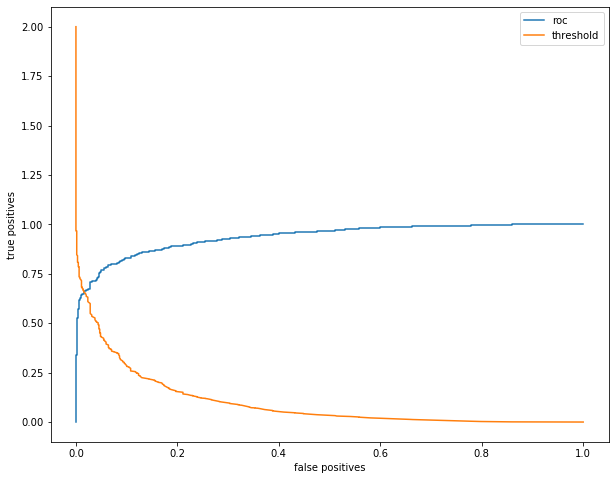

In [55]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(x_test,batch_size=2048)
auc = roc_auc_score(y_test, pred)
print("AUC score: " + str(auc))

print(">>> Saving ROC curve...")
fp , tp, th = roc_curve(y_test, pred)
plt.plot(fp, tp, label="roc")
plt.plot(fp, th, label="threshold")
plt.xlabel("false positives")
plt.ylabel("true positives")
plt.legend()

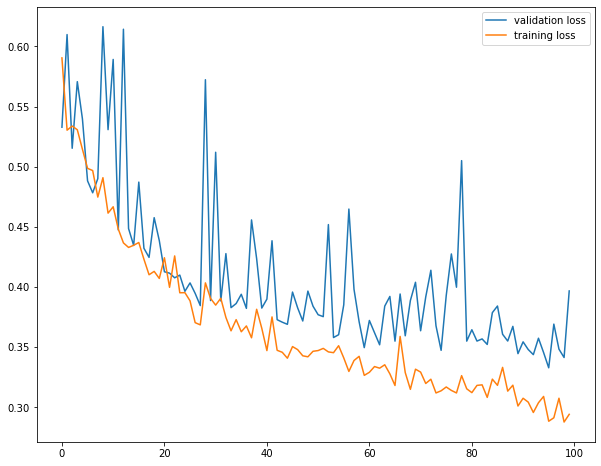

In [56]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

In [66]:
results = model.predict(x_test)

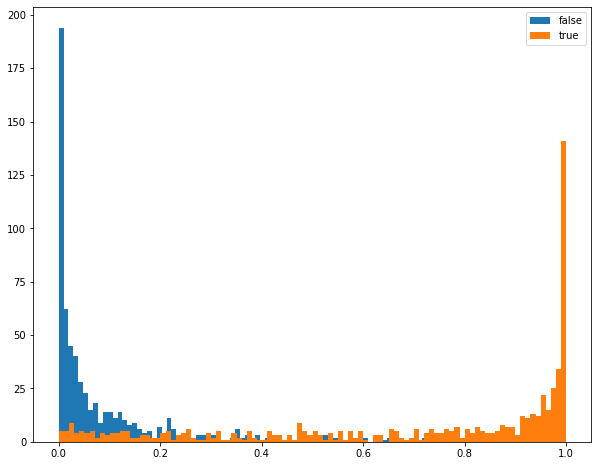

In [68]:
plt.hist(results[y_test==0], bins=100, label="false")
plt.hist(results[y_test==1], bins=100, label="true")
plt.legend()

In [69]:
reverse_sample = scaler.inverse_transform(x_test)

(array([18., 22., 32., 34., 47., 26., 12., 19., 17., 23., 16., 13., 13.,
        16., 15., 13., 16., 22., 19., 23., 14., 11.,  7., 14., 18., 41.,
        54., 30., 21., 14.]),
 array([-4.76676979, -4.45162297, -4.13647615, -3.82132933, -3.50618251,
        -3.19103569, -2.87588888, -2.56074206, -2.24559524, -1.93044842,
        -1.6153016 , -1.30015478, -0.98500797, -0.66986115, -0.35471433,
        -0.03956751,  0.27557931,  0.59072613,  0.90587294,  1.22101976,
         1.53616658,  1.8513134 ,  2.16646022,  2.48160704,  2.79675385,
         3.11190067,  3.42704749,  3.74219431,  4.05734113,  4.37248795,
         4.68763476]),
 <a list of 30 Patch objects>)

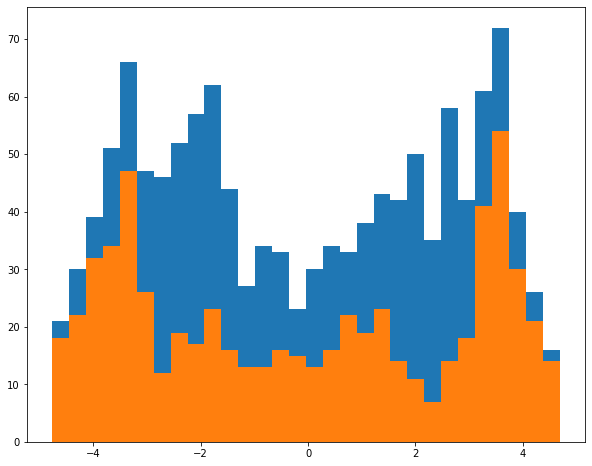

In [73]:
plt.hist(reverse_sample[:,0], bins=30)
plt.hist(reverse_sample[y_test==0, 0], bins=30)


(array([ 4.,  9.,  7., 20., 19., 23., 32., 32., 40., 38., 26., 15., 20.,
        16.,  8., 16., 19., 11., 18., 21., 20., 41., 34., 34., 31., 19.,
        20., 10.,  6.,  3.]),
 array([-4.68995424, -4.37980052, -4.06964681, -3.7594931 , -3.44933939,
        -3.13918567, -2.82903196, -2.51887825, -2.20872453, -1.89857082,
        -1.58841711, -1.27826339, -0.96810968, -0.65795597, -0.34780225,
        -0.03764854,  0.27250517,  0.58265889,  0.8928126 ,  1.20296631,
         1.51312003,  1.82327374,  2.13342745,  2.44358117,  2.75373488,
         3.06388859,  3.3740423 ,  3.68419602,  3.99434973,  4.30450344,
         4.61465716]),
 <a list of 30 Patch objects>)

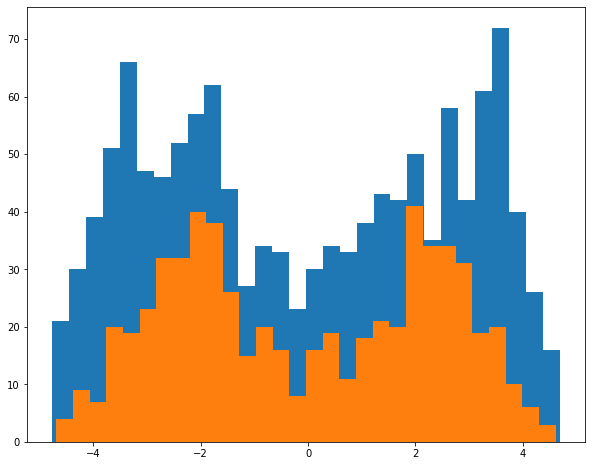

In [74]:
plt.hist(reverse_sample[:,0], bins=30)
plt.hist(reverse_sample[y_test==1, 0], bins=30)
